In [11]:
# Import packages
import nglview as ng

import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

## **Part1: Ibuprofen in water**

We start by simulating ibuprofen molecule in water. We build and simulate an extremely simple system to understand the workflow of MD simulations with GROMACS and how the theory connects to practice. 

Before we can start with the simulations, we will need the following files:
- Atom positions (.pdb, .gro)
- Topology and force field (.itp, .top)
- Simulation parameters (.mdp)

### 1.1 Building the system

#### Understanding the structure file

Let's start building our system using the 3D structure of ibuprofen. We can use nglview to visualize the structure file (.gro).

In [23]:
# Visualize the 3D structure (zoom by scrolling, rotate by dragging)
!cp 'ibu/IBU.gro' .
view = ng.show_file('IBU.gro')
view

NGLWidget()

If we look at the structure file as plain text, we see that GROMACS structure files are in .gro format, which follows always follows the format:
- Title of the structure file
- Number of atoms
- Each atom on separate lines
- Box vectors

In [24]:
# Print the first five rows in the structure file
!head -5 'IBU.gro'

Great Red Oystrich Makes All Chemists Sane
   33
    1IBU     C1    1   0.590   0.303   0.054
    1IBU     C2    2   0.446   0.252   0.061
    1IBU     C3    3   0.398   0.249   0.207


We see that each atom belong to **residue(s)**. Each line contains residue number (1), residue name (IBU), atom name, atom number, and atom xyz coordinates. Additionally the gro file can contain information about velocity.

If we print out the last line of the .gro file, we can see that is empty. That is because we have not defined the simulation box, so let's do that next.

In [25]:
!tail -1 'IBU.gro'

   0.00000   0.00000   0.00000


#### Build the simulation box

Next, we have to build the simulation box for our molecule. In this case, we center the molecule (**-c**), build a cubic box (**-bt cubic**) and then determine the box size so that the molecule is 1.0 nm from the box edge (**-d 1.0**).

In [26]:
!gmx editconf -f IBU.gro -o IBU_box.gro -c -bt cubic -d 1.0

             :-) GROMACS - gmx editconf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

------------------------------------------------------------------------------------------------------------------
**<font color='red'>Question: Why do we set the distance between ibuprofen and the box edge?</font>**

<details>
  <summary><strong>Answer:</strong></summary>
  <p> Determining large enough box size is crucial. We do this to prevent the molecule from interacting with its periodic image. </p>
</details> 
<br>

**<font color='red'>EXTRA: Why do we set the distance to 1.0 nm?</font>**

<details>
  <summary><strong>Answer:</strong></summary>
  <p> We will use CHARMM36m force field with cut-off for non-bonded interactions at 1.2 nm. Due to the periodic boundary conditions, there will be 2 x 1.0 nm between two periodic images and thus -d 1.0 is sufficient.</p>
</details>

------------------------------------------------------------------------------------------------------------------

If we print the last line from the newly generated .gro file, we see that 0 0 0 has been replaced by box vectors:

In [29]:
!tail -1 'IBU_box.gro'

   3.04991   3.04991   3.04991


#### Solvate

Now that we have the simulation box, we can will it with water molecules and save the output coordinates into a new .gro file.

In [47]:
!cp 'ibu/topol.top' .
!gmx solvate -cp IBU_box.gro -cs spc216.gro -o IBU_solvated.gro -p topol.top

             :-) GROMACS - gmx solvate, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

------------------------------------------------------------------------------------------------------------------
**<font color='red'>Question: Look at the output of gmx solvate: how many lines do you think were added to the .gro file?</font>**

<details>
  <summary><strong>Answer:</strong></summary>
  <p> The output says ''Generated solvent containing 2733 atoms in 911 residues'', thus 2733 new lines were added to the .gro file, one for each atom </p>
</details> 

------------------------------------------------------------------------------------------------------------------

#### Add ions

Next, we will use **gmx genion** tool to add ions to the system. Since gmx genion needs portable binary run input file (.tpr), we need to use another tool, **gmx grompp**, to process structure file (.gro), topology (.top) and an empty simulation parameter file (.mdp) into a tpr file.  

Once we have the binary run input file, we use gmx genion to select ion concentration as 0.15 M, and add potassium and chloride ions to produce neutral charge. 

In [50]:
# Create empty simulation parameter file
!touch empty.mdp

# Grompp, ignore warnings caused by the empty mdp file
!gmx grompp -f empty.mdp -c IBU_solvated.gro -p topol.top -o genion.tpr -maxwarn 1

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [51]:
# Replace water molecules with ions to produce charge neutral system with 0.15 M KCl concentration
!printf "SOL\n" | gmx genion -s genion.tpr -o IBU_solvated_ions.gro -conc 0.15 -p topol.top -pname K -nname CL -neutral

              :-) GROMACS - gmx genion, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Now our starting structure is ready!

In [69]:
# Visualize the 3D structure
view = ng.show_file('IBU_solvated_ions.gro')
view.add_point()
view

NGLWidget()

### 1.2 Understanding the topology and the force field files

Before we can start with the simulations, we need to define how the atoms interact with each other.

Our goal is to simulate drug-membrane interactions with CHARMM36m chosen as the force field for the lipids. Therefore, a compatible CHARMM General Forcefield (**CGenFF**) was chosen to model ibuprofen. The force field parameters for ibuprofen were obtained using CHARMM-GUI's Ligand Reader & Modeler, which uses the CGenFF tool. For water, we use CHARMM-compatible TIP3P water model. https://manual.gromacs.org/2024.5/reference-manual/topologies/topology-file-formats.html#tab-topfile2

Let's look at the topology file for our system:

In [54]:
!cat 'topol.top'

;;
;; Generated by CHARMM-GUI (http://www.charmm-gui.org) v1.7
;;
;; psf2itp_mol.py
;;
;; Correspondance:
;; jul316@lehigh.edu or wonpil@lehigh.edu
;;
;; The main GROMACS topology file
;;
;; Modified by Suvi Heinonen 3/5/2025

; Include forcefield parameters
#include "toppar/forcefield.itp"
#include "toppar/IBU.itp"
#include "toppar/tip3p.itp"
#include "toppar/ions.itp"

[ system ]
; Name
Ibuprofen in water

[ molecules ]
; Compound	#mols
IBU   	           1
SOL         905
K                3
CL               3


------------------------------------------------------------------------------------------------------------------
We have to first include the force field file, **forcefield.itp**. This file contains the atom types in your system, as well as bonded and nonbonded parameters. 

The atom types will have four static properties:    
- mass in atomic mass units
- partial charge
- Lennard-Jones parameters sigma (σ, nm) and epsilon (ε, kJ/mol)

After the atom types, the forcefield.itp lists parameters for bonds, pairs, angles and dihedrals these atoms in your system. 

------------------------------------------------------------------------------------------------------------------

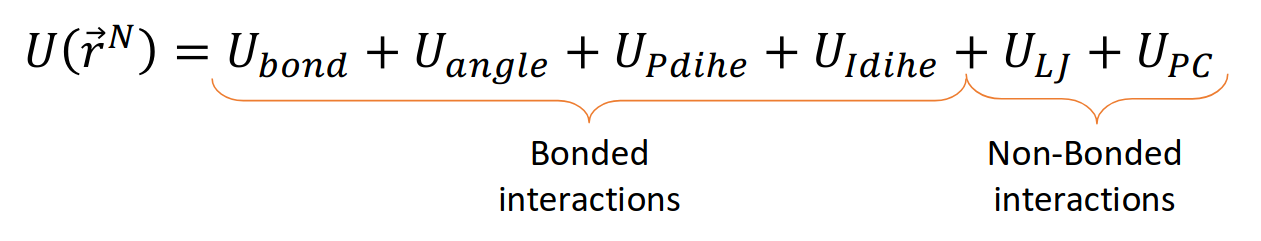

------------------------------------------------------------------------------------------------------------------
The molecular topology files (e.g., **IBU.itp**) contain information about:
- Molecule type (molecule name and how many bonds away the atoms will be excluded from non-bonded interactions)
- Atom info, including partial charges and mass (NOTE: The atom order has to be the same as in the .gro file!!!)
- Information about which atoms form pairs, bonds, angles and dihedrals
- (information about position restraints)

Take a look at the atom info and the first 5 bonds defined in the IBU.itp file:

------------------------------------------------------------------------------------------------------------------

In [68]:
# Atom info
!grep "atoms" -A 34 toppar/IBU.itp 
!echo ""
# First 5 bonds
!grep "bonds" -A 5 toppar/IBU.itp

[ atoms ]
; nr	type	resnr	residu	atom	cgnr	charge	mass
     1      CG331      1      IBU     C1      1     -0.268    12.0110   ; qtot -0.268
     2      CG311      1      IBU     C2      2     -0.118    12.0110   ; qtot -0.386
     3      CG331      1      IBU     C3      3     -0.268    12.0110   ; qtot -0.654
     4      CG321      1      IBU     C4      4     -0.159    12.0110   ; qtot -0.813
     5     CG2R61      1      IBU     C5      5     -0.007    12.0110   ; qtot -0.820
     6     CG2R61      1      IBU     C6      6     -0.118    12.0110   ; qtot -0.938
     7     CG2R61      1      IBU     C7      7     -0.071    12.0110   ; qtot -1.009
     8     CG2R61      1      IBU     C8      8     -0.083    12.0110   ; qtot -1.092
     9     CG2R61      1      IBU     C9      9     -0.071    12.0110   ; qtot -1.163
    10     CG2R61      1      IBU    C10     10     -0.118    12.0110   ; qtot -1.281
    11      CG311      1      IBU    C11     11     -0.082    12.0110   ; qtot -1.363

**<font color='red'>Question:** Look at the second bond defined in the IBU.itp under [ bonds ]. 
- What are the names of the atoms forming the bond?
- What about their atom types?

<details>
  <summary><strong>Answer:</strong></summary>
  <p> Atom names: C1-H1, atom types: CG331-HGA3 </p>
</details> 


In [55]:
# If you want to take a look at the force field file, uncomment the next line by deleting #
#!cat toppar/forcefield.itp

In [ ]:
# If you want to take a look at the topology file, uncomment the next line by deleting #
#!cat toppar/IBU.itp

### Simulations

#### Energy minimization

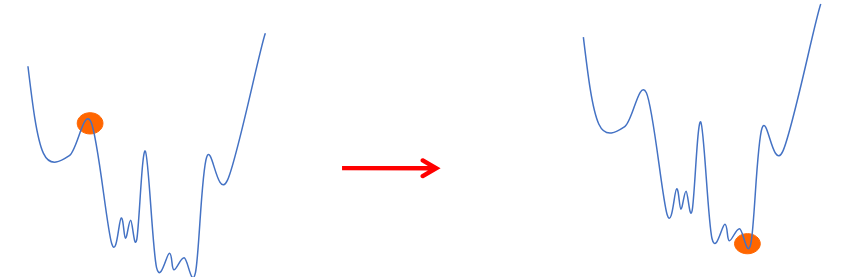

Before doing actual MD simulations, we need to get the potential energy $U(\vec{r}^N)$ smaller. For this, we will use the **steepest descent** algorithm. Let's look at the simulation parameters for the energy minimization in em.mdp:

In [73]:
!cp ibu/for_simulation/em.mdp .
!cat em.mdp

integrator              = steep
emtol                   = 1000.0
nsteps                  = 5000
nstlist                 = 10
cutoff-scheme           = Verlet
rlist                   = 1.2
vdwtype                 = Cut-off
vdw-modifier            = Force-switch
rvdw_switch             = 1.0
rvdw                    = 1.2
coulombtype             = PME
rcoulomb                = 1.2
;
constraints             = h-bonds
constraint_algorithm    = LINCS


------------------------------------------------------------------------------------------------------------------
**Question: Which parameter defines when the energy minimization stops?**

<details>
  <summary><strong>Answer:</strong></summary>
  <p>Energy minimization will go on for maximum number of 5000 steps (nsteps = 5000); it will stop if the maximumn force in the system is smaller than 1000 kJ mol-1 nm-1 (emtol = 1000.0). </p>
</details>

------------------------------------------------------------------------------------------------------------------

Now we have all necessary files to run the energy minimization. Before we can set off the minimization, we have to generate a binary run input file (.tpr) via **gmx grompp**. Then we start the minimization with **gmx mdrun**.

In [74]:
# grompp
!gmx grompp -f em.mdp -c IBU_solvated_ions.gro -p topol.top -o em.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [76]:
# Start the energy minimization
!gmx mdrun -deffnm em -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

In [78]:
!ls em*

em.edr	em.gro	em.log	em.mdp	em.png	empty.mdp  em.tpr  em.trr


              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Text(0, 0.5, 'Energy (kJ/mol)')

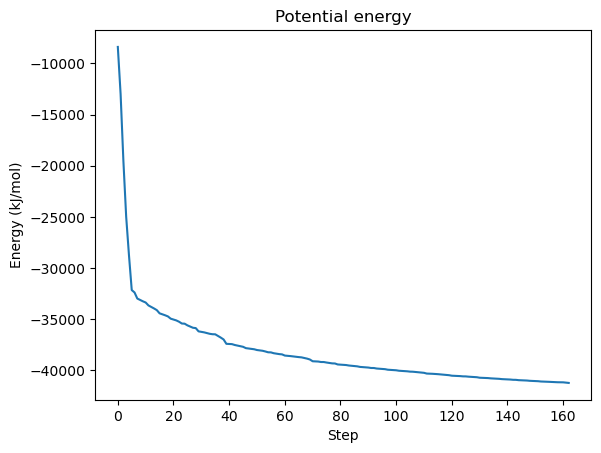

In [106]:
# Get the potential energy from the gromacs energy file
!printf "Potential\n0\n" | gmx energy -f em.edr -o em_pot.xvg -xvg none

# Plot
DATA = np.loadtxt('em_pot.xvg')

step = DATA[:,0]
energy = DATA[:,1]

plt.plot(step, energy)
plt.title('Potential energy')
plt.xlabel('Step')
plt.ylabel('Energy (kJ/mol)')

#### Equilibration (NVT)

Now we can start simulating the dynamics! Often times it's a good idea to first add temperature to the system, i.e., perform the simulation under canonical ensemble. Let's look at the simulation parameters:

In [98]:
!cat nvt.mdp

integrator              = md
dt                      = 0.001
nsteps                  = 125000
nstxtcout               = 5000
nstvout                 = 5000
nstfout                 = 5000
nstcalcenergy           = 100
nstenergy               = 1000
nstlog                  = 1000
;
cutoff-scheme           = Verlet
nstlist                 = 20
rlist                   = 1.2
vdwtype                 = Cut-off
vdw-modifier            = Force-switch
rvdw_switch             = 1.0
rvdw                    = 1.2
coulombtype             = PME
rcoulomb                = 1.2
;
tcoupl                  = v-rescale
tc_grps                 = System
tau_t                   = 1.0
ref_t                   = 310.15
;
constraints             = h-bonds
constraint_algorithm    = LINCS
;
nstcomm                 = 100
comm_mode               = linear
comm_grps               = System
;
gen-vel                 = yes
gen-temp                = 310.15
gen-seed                = -1


In [99]:
!gmx grompp -f nvt.mdp -c em.gro -p topol.top -o nvt.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [100]:
# Start the energy minimization
!gmx mdrun -deffnm nvt -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

The run will take approximately 5-6 minutes. Meanwhile, let's look at some of the run parameters:

- **integrator = md** ; use leap-frog algorithm for integrating the Newton’s equations of motion
- **tcoupl = v-rescale** ; temperature coupling using velocity rescaling with a stochastic term, time constant and target temperature are set separately
- **gen-vel = yes** ; generate velocities with Maxwell distribution at temperature gen-temp (which is 310.15 K in our case)

Let's visualize our simulation:

In [113]:
traj = md.load('nvt.xtc', top='nvt.gro')
view = ng.show_mdtraj(traj)
view.add_point()
view.center()
view.camera='orthographic'
view.add_unitcell()
view

NGLWidget(max_frame=25)

We can then check the convergence of temperature using the gmx energy tool and the energy file:

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Text(0, 0.5, 'Temperature (K)')

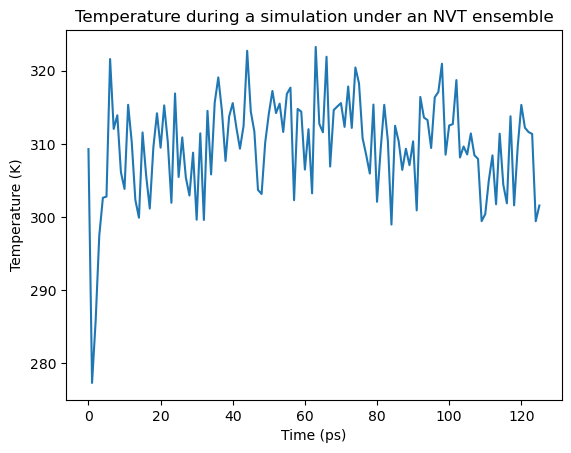

In [115]:
!printf "Temperature\n0\n" | gmx energy -f nvt.edr -o nvt_temperature.xvg -xvg none

DATA = np.loadtxt('nvt_temperature.xvg')

time = DATA[:,0]
temperature= DATA[:,1]

plt.plot(time, temperature)
plt.title('Temperature during a simulation under an NVT ensemble')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')

#### More equilibration under an NPT ensemble and the production run

In [118]:
!cat production.mdp 

integrator              = md
dt                      = 0.002
nsteps                  = 125000000 ; 250 ns
nstxout-compressed      = 5000 ; writing xtc every 10 ps
nstxout			= 5000000 ;writing .trr, every 10 ns
nstvout                 = 5000000 ;writing velocities for .trr, every 10 ns 
nstfout                 = 5000000 ;writing forces for .trr, every 10 ns
nstcalcenergy           = 100
nstenergy               = 1000
nstlog                  = 1000
;
cutoff-scheme           = Verlet
nstlist                 = 20
vdwtype                 = Cut-off
vdw-modifier            = Force-switch
rvdw_switch             = 1.0
rvdw                    = 1.2
rlist                   = 1.2
rcoulomb                = 1.2
coulombtype             = PME
;
pcoupl                  = c-rescale             
pcoupltype              = isotropic            
tau_p                   = 5.0               
ref_p                   = 1.0                
compressibility         = 4.5e-5               
refcoord_scaling        

In [117]:
!gmx grompp -f production.mdp -c nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [122]:
#!gmx mdrun -deffnm npt -nsteps 50000 -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

In [12]:
ibu_edr='ibu_full_simulation/run_IBU_solvated_ions.edr'
ibu_tpr='ibu_full_simulation/run_IBU_solvated_ions.tpr'
ibu_xtc='ibu_full_simulation/run_IBU_solvated_ions.xtc'
ibu_gro='ibu_full_simulation/run_IBU_solvated_ions.gro'

In [150]:
!printf "0\n" | gmx trjconv -s $ibu_tpr -f $ibu_xtc -o ibu_nopbc.xtc -pbc mol

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [13]:
traj = md.load('ibu_nopbc.xtc', top=gro)
view = ng.show_mdtraj(traj)
view.add_point()
view.center()
view.camera='orthographic'
view.add_unitcell()
view

NameError: name 'gro' is not defined

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Text(0, 0.5, 'Pressure')

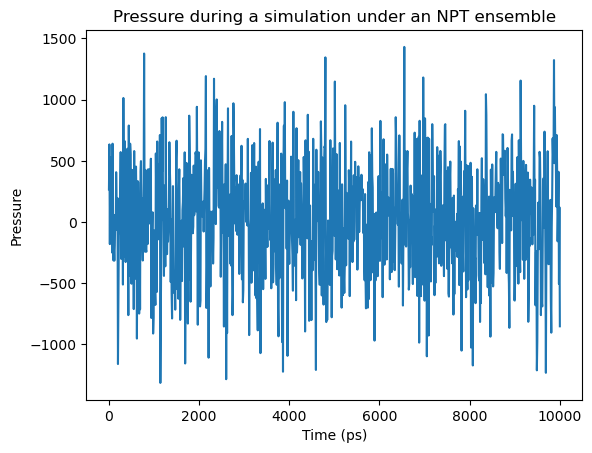

In [126]:
edr='ibu_full_simulation/*edr'

!printf "Pressure\n0\n" | gmx energy -f $edr -o npt_pressure.xvg -xvg none

DATA = np.loadtxt('npt_pressure.xvg')

time = DATA[:,0]
pressure= DATA[:,1]

plt.plot(time, pressure)
plt.title('Pressure during a simulation under an NPT ensemble')
plt.xlabel('Time (ps)')
plt.ylabel('Pressure')

In [5]:
memb_ibu_edr='memb_ibu_full_simulation/run_memb_ibu.edr'
memb_ibu_tpr='memb_ibu_full_simulation/run_memb_ibu.tpr'
memb_ibu_xtc='memb_ibu_full_simulation/run_memb_ibu.xtc'
memb_ibu_gro='memb_ibu_full_simulation/run_memb_ibu.gro'

In [6]:
!printf "0\n" | gmx trjconv -s $memb_ibu_tpr -f $memb_ibu_xtc -o memb_ibu_nopbc.xtc -pbc mol -e 100000

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [14]:
traj = md.load('memb_ibu_nopbc.xtc', top=memb_ibu_gro)

view = ng.show_mdtraj(traj)
view.clear_representations('IBU')

view.add_spacefill('IBU', color='orange')

view.camera='orthographic'
view.add_unitcell()
view

NGLWidget(max_frame=1000)

In [10]:
# Box vectors, xy
!printf "Box-X \n Box-Y \n 0 \n" | gmx energy -f $memb_ibu_edr -o box_xy.xvg -xvg none -e 100000

# Number of contacts within cutoff
!printf "IBU \n Water \n" | gmx mindist -f $memb_ibu_xtc -s $memb_ibu_tpr -n analysis.ndx -on ncontacts_ibu.xvg -xvg none -e 100000

# Distance between box center and IBU
#selection="com of resname IBU plus com of resname POPC"
!gmx distance -f $memb_ibu_xtc -s $memb_ibu_tpr -n analysis.ndx -oxyz distz.xvg -xvg none -e 100000 -select "$selection"

              :-) GROMACS - gmx energy, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [65]:
def plot_xvg(analysis_type, ax):
    """
    Plot .xvg files
    
    analysis_type (str): 'distz', 'ncontacts' or 'box_xy' 
    ax (matplotlib.axes.Axes) = axis to plot on
    """

    # Check if file exists:
    
    DATA = np.loadtxt(f'{analysis_type}.xvg')

    time = DATA[:,0]

    if analysis_type == 'distz':
        result = DATA[:,3]
        title = 'Distance between IBU-com and membrane-com in Z direction'
        ylabel = 'Distance (nm)'
    elif analysis_type == 'ncontacts_ibu':
        result = DATA[:,1]
        title = 'Number of contacts between IBU and Water (< 0.6 nm)'
        ylabel = 'Number'
    elif analysis_type == 'ncontacts_memb':
        result = DATA[:,1]
        title = 'Number of contacts between POPC and Water (< 0.6 nm)'
        ylabel = 'Number'
    elif analysis_type == 'box_xy':
        nlipids = 64
        result = (DATA[:,1]*DATA[:,2])/nlipids
        title = 'Area per lipid'
        ylabel = 'Area per lipid ($nm²$)'
    else:
        raise ValueError('Analysis type must be one of the following: distz, ncontacts, box_xy')

    ax.plot(time, result)
    ax.set_title(title, weight='bold')
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel(ylabel)

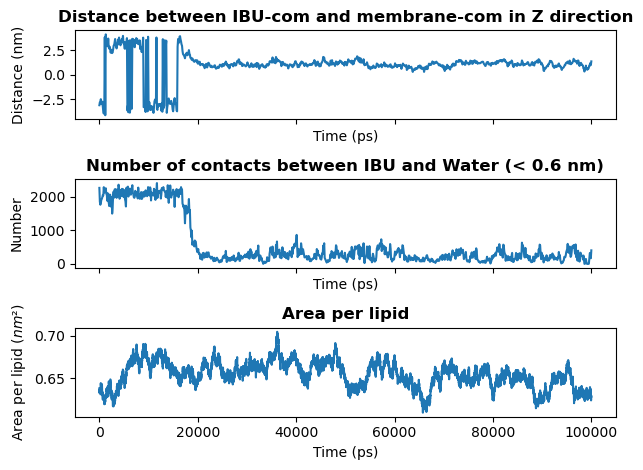

In [67]:
analyses = 'distz', 'ncontacts_ibu', 'ncontacts_ibu', 'box_xy'

fig, axs = plt.subplots(4,1, sharex=True)

for ax, analysis in zip(axs, analyses):
    plot_xvg(analysis, ax)

fig.tight_layout()

In [59]:
# Mass density
!printf "POPC \n POPC \n P \n IBU \n Water \n" | gmx density -f $memb_ibu_xtc -s $memb_ibu_tpr -n analysis_groups.ndx -o mass_density.xvg -ng 4 -sl 100 -d z -center -b 50000 -e 100000 -xvg none

             :-) GROMACS - gmx density, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

Text(0, 0.5, 'Density ($kgm^{⁻3}$)')

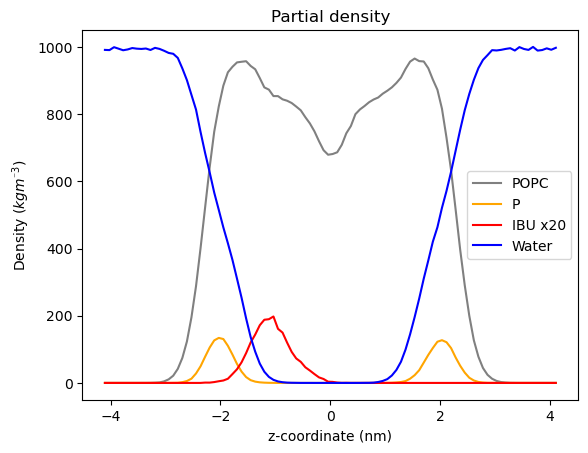

In [60]:
DATA = np.loadtxt('mass_density.xvg')

atom_groups = 'POPC', 'P', 'IBU', 'Water'
colors = 'grey', 'orange', 'red', 'blue'

for i, ag in enumerate(atom_groups):
    color = colors[i]
    distance = DATA[:,0]

    if ag != 'IBU':
        density = DATA[:,i+1]
    else:
        density = DATA[:,i+1]*20
        ag=f'{ag} x20'

    plt.plot(distance, density, color=color, label=ag)

plt.legend()
plt.title('Partial density')
plt.xlabel('z-coordinate (nm)')
plt.ylabel('Density ($kgm^{⁻3}$)')

What next?
- Doing replicates
- Analyzing the effect of ibuprofen concentration
- Free energy calculations with e.g. Accelerated Weighted Histogram method --> assessing permeation?